**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.7\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m18-improved.csv'
path_dump_improved = '../output/m20-improved.csv' # output solution

num_cpu_cores = 22
#time_limit = -1 # unlimited
time_limit = 6*24*60*60  # in s

occupancy_diff = 150  # +- the occupancy of input solution for each day
occupancy_diff_low = 20  # +- the occupancy of input solution for each day
max_family_rank = 9  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = True  # use occupancy_counts as variable (seem faster)
redundant_occupancy_constraints = True  # use redundant constraints
min_choice_0_families = 0   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 0 # 5494.41999786889
max_accounting_cost_per_day = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69712.41999786888
Preference cost: 64218
Accounting cost: 5494.41999786889


In [9]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 285 263 255 253 271 296 300 297 273 262 258 273 296
 290 274 247 223 232 256 282 300 292 273 257 249 246 275 275 256 224 195
 167 192 227 251 236 206 176 153 125 294 276 252 219 188 156 125 281 260
 231 195 160 127 125 263 238 205 163 125 125 125 245 219 183 139 125 125
 125 225 206 175 128 125 125 125 229 211 181 138 126 125 125 253 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

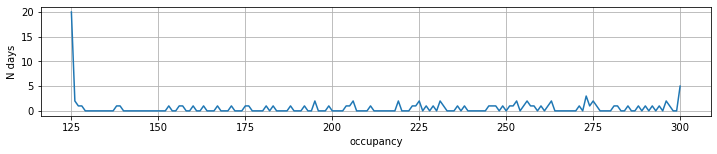

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

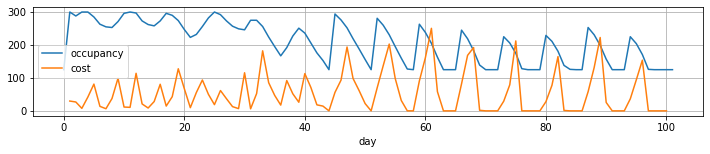

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       29.788443
2       26.920185
3        7.577722
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]])

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]])

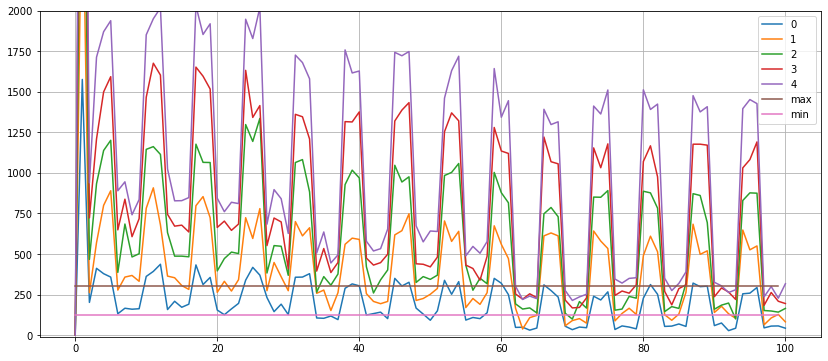

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

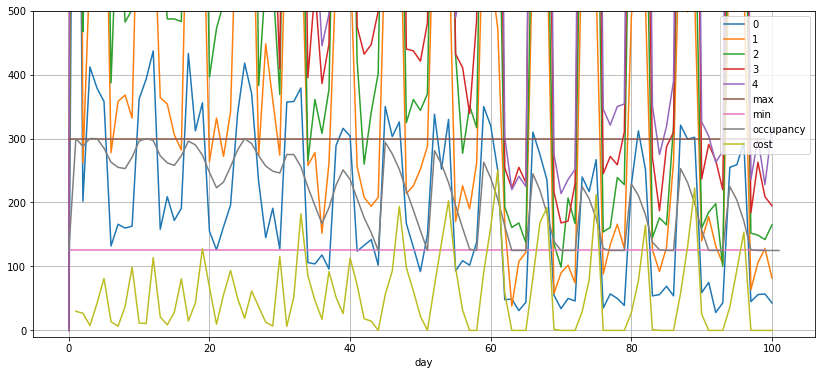

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

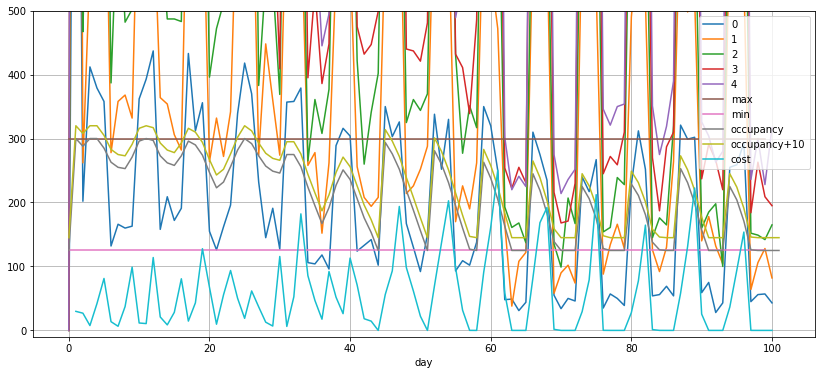

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

In [23]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    if day == 1:
        search_occupancy[day] = [N_max_people]
    elif day == N_days:
        search_occupancy[day] = [N_min_people]
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [24]:
for i, x in search_occupancy.items():
    print(i, x)

1 [300]
2 range(138, 301)
3 range(150, 301)
4 range(150, 301)
5 range(135, 301)
6 range(125, 301)
7 range(125, 301)
8 range(125, 301)
9 range(125, 301)
10 range(146, 301)
11 range(150, 301)
12 range(147, 301)
13 range(125, 301)
14 range(125, 301)
15 range(125, 301)
16 range(125, 301)
17 range(146, 301)
18 range(140, 301)
19 range(125, 301)
20 range(125, 301)
21 range(125, 301)
22 range(125, 301)
23 range(125, 301)
24 range(132, 301)
25 range(150, 301)
26 range(142, 301)
27 range(125, 301)
28 range(125, 301)
29 range(125, 301)
30 range(125, 301)
31 range(125, 301)
32 range(125, 301)
33 range(125, 301)
34 range(125, 301)
35 range(125, 301)
36 range(125, 301)
37 range(125, 301)
38 range(125, 301)
39 range(125, 301)
40 range(125, 301)
41 range(125, 301)
42 range(125, 301)
43 range(125, 301)
44 range(125, 146)
45 range(144, 301)
46 range(126, 301)
47 range(125, 301)
48 range(125, 301)
49 range(125, 301)
50 range(125, 301)
51 range(125, 146)
52 range(131, 301)
53 range(125, 301)
54 range(125

In [25]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [26]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

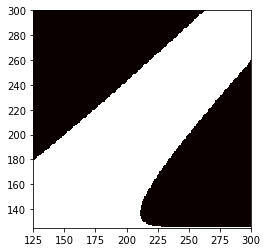

In [27]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [28]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 9


In [29]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, ..., 372, 444, 544],
       [  0,  50,  86, ..., 372, 444, 544],
       [  0,  50,  77, ..., 354, 408, 508],
       ...,
       [  0,  50, 104, ..., 408, 516, 616],
       [  0,  50,  95, ..., 390, 480, 580],
       [  0,  50,  86, ..., 372, 444, 544]], dtype=int64)

## DOCplex model

In [30]:
from docplex.mp.model import Model

In [31]:
solver = Model('')

In [32]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 22
Num treads: threads:int(22)
Set time limit: None


In [33]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [34]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [35]:
len(assignment_matrix)

45000

In [36]:
possible_family_sizes = np.unique(n_people)

In [37]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [38]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [39]:
search_occupancy[N_days]

[125]

In [40]:
len(occupancy_matrix)

1050048

## Constraints

### constraint 1: each family only take one day (choice)

In [41]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [42]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [43]:
# constraint 2: each day can only have 125-300 people

In [44]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

9

In [45]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [46]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [47]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [48]:
if not occupancy_count_as_variables:
    for day in days:
        solver.add_range(min(search_occupancy[day]), 
                         occupancy_counts[day], 
                         max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [49]:
# constraint 3: unpreferred day family count conservation for each family size

In [50]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [51]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [52]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [53]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [54]:
# next day occupancy consistency
solver.add_constraints_([
    occupancy_counts[day + 1] == solver.sum([
        occupancy_matrix[day, o, o_next] * o_next 
        for o in search_occupancy[day]
        for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next]            
    ])
    for day in days if day < N_days
])

# redudant constraints
if redundant_occupancy_constraints:
    for day in days:
        if day + 1 < N_days:
            solver.add_constraints_([
                solver.sum([
                    occupancy_matrix[day, o_other, o] 
                    for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]
                ]) == solver.sum([
                    occupancy_matrix[day + 1, o, o_other]
                    for o_other in search_occupancy[day + 2] if viable_nd_ndp1[o, o_other]
                ])
                for o in search_occupancy[day + 1]
            ])
    solver.add_constraints_([
        solver.sum([
            occupancy_matrix[N_days - 1, o_other, o] 
            for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]
        ]) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        for o in search_occupancy[N_days]
    ])

### Preference cost

In [55]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [56]:
if target_pref_cost > 0:
    print('limit preference cost')
    if target_pref_cost_error > 0:
        solver.add_constraints_([
            family_pref_cost <= target_pref_cost + target_pref_cost_error,
            family_pref_cost >= target_pref_cost - target_pref_cost_error
        ])
    else:
        solver.add_constraint_(family_pref_cost == target_pref_cost)

### Accounting cost

In [57]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [58]:
if target_accounting_cost > 0:
    if target_accounting_cost_error > 0:
        print('Range limit accounting cost')
        solver.add_range(
            target_accounting_cost - target_accounting_cost_error,
            accounting_cost,
            target_accounting_cost - target_accounting_cost_error
        )
elif target_accounting_cost_lower > 0:
    print('Lower bound accounting cost')
    solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)

In [59]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [60]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [61]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

Using hint!


## Solve

In [62]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [63]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = initial_score or 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [64]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [65]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 1095148 ( 1095048 , 100 )
N of constraints: 19335
Time limit: 518400.0


In [ ]:
%%time
# Solve
sol = solver.solve(log_output=True)

if sol is None:
    sol = my_progress_listener.get_solutions()[-1]

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 22
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               518400
CPXPARAM_MIP_Tolerances_MIPGap                   0
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69712.4200.
Tried aggregator 1 time.
MIP Presolve eliminated 1837 rows and 148259 columns.
MIP Presolve modified 2 coefficients.
Reduced MIP has 17498 rows, 946889 columns, and 4599133 nonzeros.
Reduced MIP has 946791 binaries, 98 generals, 0 SOSs, and 0 indicators.
Presolve time = 2.20 sec. (2362.52 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17498 rows, 946889 columns, and 4599133 nonzeros.
Reduced MIP has 946791 binaries, 98 generals, 0 SOSs, and 0 indicators.
Presolve time = 3.17 sec. (2681.56 ticks)
Probing time = 1.08 sec. (584.63 ticks)
Cliq

     60    50    68441.6632   988    69712.4200    68411.5026   100916    1.87%
     61    42    68442.8081   965    69712.4200    68411.5026    92487    1.87%
     63    15    68668.1520   780    69712.4200    68411.5026    73131    1.87%
     64    47    68436.9758   980    69712.4200    68411.5026    98584    1.87%
     65    52    68438.2582  1002    69712.4200    68411.5026   103202    1.87%
     67    16    68654.5399   707    69712.4200    68411.5026    72829    1.87%
     68    57    68443.6156   945    69712.4200    68411.5026   109864    1.87%
Elapsed time = 2291.13 sec. (3242172.71 ticks, tree = 11.16 MB, solutions = 1)
     71    56    68781.1054   612    69712.4200    68411.5026   107299    1.87%
     72    57    68781.1241   614    69712.4200    68411.5026   107372    1.87%
     73    45    68442.9308   970    69712.4200    68411.5026    93300    1.87%
     75    58    68443.8680   972    69712.4200    68411.5026   110104    1.87%
     76    43    68444.3797   976    6971

    327   252    68916.6115   625    69712.4200    68411.5026   430889    1.87%
    331   253    68917.0283   604    69712.4200    68411.5026   431141    1.87%
    345   278    68963.1223   460    69712.4200    68411.5026   439937    1.87%
Elapsed time = 3560.16 sec. (3642632.59 ticks, tree = 66.23 MB, solutions = 1)
    350   244    68923.7204   435    69712.4200    68411.5026   416601    1.87%
    355   231    68939.8449   529    69712.4200    68411.5026   412230    1.87%
    360   256    68944.5979   565    69712.4200    68411.5026   432334    1.87%
    364   236    68941.1237   496    69712.4200    68411.5026   412817    1.87%
    369   266    69188.2947   413    69712.4200    68411.5026   438885    1.87%
    372   247    69200.4844   373    69712.4200    68411.5026   420080    1.87%
    378   250    69200.7970   310    69712.4200    68411.5026   420445    1.87%
    389   236    69209.3187   402    69712.4200    68411.5026   418313    1.87%
    401   260    69203.8577   219    6971

   4769  2578    69483.5357   148    69712.4200    68411.5026   764415    1.87%
   4828  2547    69676.7218    78    69712.4200    68411.5026   724150    1.87%
   4904  2554    69111.1960   220    69712.4200    68411.5026   792981    1.87%
   4970  2561    69111.8510   199    69712.4200    68411.5026   793260    1.87%
   5035  2644    69592.7303   124    69712.4200    68411.5026   766915    1.87%
   5098  2661    69614.7540   148    69712.4200    68411.5026   767261    1.87%
   5171  2518    68988.4635   203    69712.4200    68411.5026   787658    1.87%
   5245  2596    69135.3717   175    69712.4200    68411.5026   794919    1.87%
   5320  2711    69668.4237   114    69712.4200    68411.5026   768274    1.87%
   5388  2726    69691.0784   108    69712.4200    68411.5026   768721    1.87%
Elapsed time = 4941.94 sec. (4104489.69 ticks, tree = 1216.69 MB, solutions = 1)
   5459  2608    69285.5158   132    69712.4200    68411.5026   784464    1.87%
   5526  2753        cutoff          69

   9379  8327    69572.6921   104    69712.4200    68411.5026  1168704    1.87%
   9420  8343    69579.7343   111    69712.4200    68411.5026  1169350    1.87%
   9440  8358    69600.6489   126    69712.4200    68411.5026  1169600    1.87%
   9466  8273    69012.1247   228    69712.4200    68411.5026  1172243    1.87%
   9498  8277    69017.6364   232    69712.4200    68411.5026  1172684    1.87%
   9532  9007    69135.1741   132    69712.4200    68411.5026  1205649    1.87%
   9556  8292    69020.8116   221    69712.4200    68411.5026  1173530    1.87%
   9580  8299    69021.3599   221    69712.4200    68411.5026  1173856    1.87%
   9601  8305    69022.9775   206    69712.4200    68411.5026  1174103    1.87%
   9631  9071    69195.7641   161    69712.4200    68411.5026  1207113    1.87%
Elapsed time = 6038.63 sec. (4457116.10 ticks, tree = 4553.94 MB, solutions = 1)
Nodefile size = 2414.97 MB (896.48 MB after compression)
   9658  8326    69037.2601   175    69712.4200    68411.5026 

  10459     4    68863.2369   819    69712.4200    68693.6111  1684617    1.46%
  10461     6    68864.1653   848    69712.4200    68693.6111  1685185    1.46%
  10462     3    68693.6391  1155    69712.4200    68693.6111  1678235    1.46%
  10463     8    68693.7040  1154    69712.4200    68693.6396  1685405    1.46%
Elapsed time = 9766.84 sec. (10567763.35 ticks, tree = 0.02 MB, solutions = 1)
  10464     7    69072.7549   632    69712.4200    68693.6396  1690584    1.46%
  10466    11    68833.1538   782    69712.4200    68693.7058  1694464    1.46%
  10468    12    68833.2334   797    69712.4200    68693.7058  1694655    1.46%
  10469    13    69076.1049   611    69712.4200    68693.7058  1695553    1.46%
  10470     9    68693.9990  1137    69712.4200    68693.7058  1685734    1.46%
  10472     9    68697.4397  1066    69712.4200    68693.7058  1687568    1.46%
  10473    16        cutoff          69712.4200    68694.0006  1698673    1.46%
  10476    17    68833.2433   797    6971

Elapsed time = 11221.36 sec. (11063992.81 ticks, tree = 90.05 MB, solutions = 1)
  10974   398    68878.5574   845    69712.4200    68695.0668  1985701    1.46%
  10982   338    68901.2827   790    69712.4200    68695.0668  1949851    1.46%
  10985   415    69256.7643   424    69712.4200    68695.0668  1990131    1.46%
  10992   416    68696.1618  1127    69712.4200    68695.0668  1992921    1.46%
  11001   400    68975.4910   788    69712.4200    68695.0668  1983876    1.46%
  11004   417    69258.7392   431    69712.4200    68695.0668  1990938    1.46%
  11013   404    68975.5442   788    69712.4200    68695.0668  1984184    1.46%
  11023   313    68991.9566   745    69712.4200    68695.0668  1932857    1.46%
  11029   458    68921.0333   789    69712.4200    68695.0668  2011992    1.46%
  11031   388    69071.1724   483    69712.4200    68695.0668  1976332    1.46%
Elapsed time = 11381.08 sec. (11105490.41 ticks, tree = 93.43 MB, solutions = 1)
  11042   328    69699.2417   473    6

  12049  1134    69325.3159   611    69712.4200    68695.0668  2392266    1.46%
  12061  1106    68841.7089   665    69712.4200    68695.0668  2375125    1.46%
  12078  1123    69507.1126   231    69712.4200    68695.0668  2374678    1.46%
  12095  1127    69517.2041   226    69712.4200    68695.0668  2375109    1.46%
  12113  1347    69508.2059   191    69712.4200    68695.0668  2485039    1.46%
  12129  1305    69097.7777   303    69712.4200    68695.0668  2468171    1.46%
  12149  1227    69441.3938   398    69712.4200    68695.0668  2439068    1.46%
Elapsed time = 12644.91 sec. (11475627.74 ticks, tree = 399.85 MB, solutions = 1)
  12168  1230    69442.9484   386    69712.4200    68695.0668  2439431    1.46%
  12179  1119    69023.5396   612    69712.4200    68695.0668  2388160    1.46%
  12188  1309    69099.4751   221    69712.4200    68695.0668  2469536    1.46%
  12215  1311    69100.3165   229    69712.4200    68695.0668  2469909    1.46%
  12242  1239    69443.0614   379    6

  14311  2985    68847.4608   691    69712.4200    68695.0668  2861078    1.46%
  14318  2472    68712.5528   927    69712.4200    68695.0668  2820588    1.46%
  14324  3013    69226.6828   402    69712.4200    68695.0668  2866422    1.46%
Elapsed time = 13954.72 sec. (11835006.98 ticks, tree = 1246.55 MB, solutions = 1)
  14327  3015    69229.9349   404    69712.4200    68695.0668  2866682    1.46%
  14331  3019    68919.7820   542    69712.4200    68695.0668  2881569    1.46%
  14338  3105    69592.9365   561    69712.4200    68695.0668  2915681    1.46%
  14347  3109    69584.1180   589    69712.4200    68695.0668  2916128    1.46%
  14350  3033    69380.7566   470    69712.4200    68695.0668  2894388    1.46%
  14355  3034    69023.7703   607    69712.4200    68695.0668  2894548    1.46%
  14357  3144    69235.4813   399    69712.4200    68695.0668  2924976    1.46%
  14362  3145    69235.6571   396    69712.4200    68695.0668  2925260    1.46%
  14364  3081    69344.5260   537    

  14606  3701    68892.6436   439    69712.4200    68695.0668  3173172    1.46%
  14610  3703    68892.7260   435    69712.4200    68695.0668  3173371    1.46%
  14614  3729    69460.4788   353    69712.4200    68695.0668  3183702    1.46%
  14617  3731    69462.0268   383    69712.4200    68695.0668  3184008    1.46%
  14623  3733    69462.1917   353    69712.4200    68695.0668  3184414    1.46%
  14632  3738    69462.7496   347    69712.4200    68695.0668  3184792    1.46%
  14637  3740    69463.6125   379    69712.4200    68695.0668  3185212    1.46%
  14642  3743    69466.4744   360    69712.4200    68695.0668  3185568    1.46%
  14645  3740    69047.8166   620    69712.4200    68695.0668  3192496    1.46%
  14651  3707    68896.3772   457    69712.4200    68695.0668  3176017    1.46%
Elapsed time = 16880.64 sec. (13602587.43 ticks, tree = 1585.85 MB, solutions = 1)
  14657  3682    69425.9150   491    69712.4200    68695.0668  3170775    1.46%
  14662  3742    69042.5114   595    

  15449  4437    69282.3048   147    69712.4200    68695.0668  3439199    1.46%
  15476  4284    69705.5522   231    69712.4200    68695.0668  3429708    1.46%
  15503  4461    69303.4659   108    69712.4200    68695.0668  3439887    1.46%
  15520  4473    69294.6309   117    69712.4200    68695.0668  3440327    1.46%
  15535  4483    69296.2665   150    69712.4200    68695.0668  3440619    1.46%
  15548  4495    69319.9257   160    69712.4200    68695.0668  3441220    1.46%
Elapsed time = 17848.53 sec. (14006861.93 ticks, tree = 1976.29 MB, solutions = 1)
  15564  4125    69611.7284   487    69712.4200    68695.0668  3415183    1.46%
  15579  4093    69408.9384   439    69712.4200    68695.0668  3397624    1.46%
  15590  4433    68967.9946   719    69712.4200    68695.0668  3448880    1.46%
  15596  4097    69409.9009   442    69712.4200    68695.0668  3398256    1.46%
  15615  4534    69331.4248   121    69712.4200    68695.0668  3442288    1.46%
  15631  4548    69335.0435   114    

  16509  5242    69040.5170   635    69712.4200    68695.0668  3619066    1.46%
  16514  4700    69297.9963   366    69712.4200    68695.0668  3573648    1.46%
  16521  5327    69476.8271   216    69712.4200    68695.0668  3670158    1.46%
  16525  5328    69483.3779   215    69712.4200    68695.0668  3670622    1.46%
  16531  5332    69492.0554   186    69712.4200    68695.0668  3671070    1.46%
Elapsed time = 18746.86 sec. (14396757.36 ticks, tree = 2397.05 MB, solutions = 1)
Nodefile size = 334.36 MB (131.27 MB after compression)
  16537  5335    69489.4303   200    69712.4200    68695.0668  3671636    1.46%
  16541  5284    68711.6113   986    69712.4200    68695.0668  3651333    1.46%
  16545  5280    68940.9154   490    69712.4200    68695.0668  3636911    1.46%
  16551  5339    69488.9877   136    69712.4200    68695.0668  3673274    1.46%
  16555  5343    69495.0695   220    69712.4200    68695.0668  3673719    1.46%
  16561  5346    69501.5886   178    69712.4200    68695.0668

  17859  6443    69303.3370   161    69712.4200    68695.0668  4182483    1.46%
  17905  6685    69317.3641   186    69712.4200    68695.0668  4315866    1.46%
  17945  6705    69340.3181   205    69712.4200    68695.0668  4317841    1.46%
  17988  6731    69362.7062   185    69712.4200    68695.0668  4319906    1.46%
  18060  6780    69371.8918   149    69712.4200    68695.0668  4321613    1.46%
  18111  6816    69384.8130   152    69712.4200    68695.0668  4322514    1.46%
  18156  6845    69416.1416   131    69712.4200    68695.0668  4323292    1.46%
  18249  6911    69472.9653   138    69712.4200    68695.0668  4324403    1.46%
Elapsed time = 21271.33 sec. (15374144.37 ticks, tree = 3168.89 MB, solutions = 1)
Nodefile size = 978.00 MB (387.39 MB after compression)
  18346  6977    69533.1649   118    69712.4200    68695.0668  4325677    1.46%
  18426  6837    69655.7040   451    69712.4200    68695.0668  4406805    1.46%
  18513  7087    69570.8312   146    69712.4200    68695.0668

Nodefile size = 2551.45 MB (1009.90 MB after compression)
  21584 10187    69027.5003   725    69712.4200    68695.0668  5544938    1.46%
  21611  9638    69165.9112   310    69712.4200    68695.0668  5397339    1.46%
  21625  9792    69477.0874   519    69712.4200    68695.0668  5457922    1.46%
  21653  9780    68787.5449   786    69712.4200    68695.0668  5467700    1.46%
  21677  9869    69583.0755   335    69712.4200    68695.0668  5516609    1.46%
  21700  9754    69050.3796   613    69712.4200    68695.0668  5442387    1.46%
  21719  9799    69089.9414   694    69712.4200    68695.0668  5487469    1.46%
  21759  9718    68726.2255   984    69712.4200    68695.0668  5423337    1.46%
  21788 10225    68829.4203   733    69712.4200    68695.0668  5576709    1.46%
  21810 10396    69482.8156   459    69712.4200    68695.0668  5671472    1.46%
Elapsed time = 25329.97 sec. (16780262.79 ticks, tree = 4860.03 MB, solutions = 1)
Nodefile size = 2797.92 MB (1107.30 MB after compression)
 

  23872 12028    69377.3273   316    69712.4200    68695.0668  6698289    1.46%
  23898 12307    69142.7187   410    69712.4200    68695.0668  6879474    1.46%
Elapsed time = 29455.53 sec. (18061749.09 ticks, tree = 5767.78 MB, solutions = 1)
Nodefile size = 3700.21 MB (1458.31 MB after compression)
  23923 12083    69423.7285   540    69712.4200    68695.0668  6724092    1.46%
  23952 12365    69382.8932   241    69712.4200    68695.0668  6917456    1.46%
  23970 12097    68822.3808   527    69712.4200    68695.0668  6733663    1.46%
  23995 12240    69106.7271   563    69712.4200    68695.0668  6829179    1.46%
  24018 12418    69431.6378   519    69712.4200    68695.0668  6940304    1.46%
  24035 12267    69123.7451   738    69712.4200    68695.0668  6857718    1.46%
  24055 12205    69107.5970   588    69712.4200    68695.0668  6798955    1.46%
  24073 12388    69608.4033   257    69712.4200    68695.0668  6927475    1.46%
  24110 12312    68945.0285   811    69712.4200    68695.06

  26044 14026    68839.3964   528    69712.4200    68695.0668  7954321    1.46%
  26065 13995    68735.8986   931    69712.4200    68695.0668  7946720    1.46%
  26085 13986    68736.3143   923    69712.4200    68695.0668  7937094    1.46%
  26111 14329    68764.1601   943    69712.4200    68695.0668  8111461    1.46%
  26131 14196    69181.9224   516    69712.4200    68695.0668  8021540    1.46%
Elapsed time = 34214.55 sec. (19495701.40 ticks, tree = 6664.73 MB, solutions = 1)
Nodefile size = 4599.51 MB (1800.08 MB after compression)
  26153 14332    68765.6548   947    69712.4200    68695.0668  8112627    1.46%
  26172 14334    68766.0383   925    69712.4200    68695.0668  8113219    1.46%
  26190 14160    68866.7029   589    69712.4200    68695.0668  8005849    1.46%
  26207 14165    69205.0456   610    69712.4200    68695.0668  8009495    1.46%
  26231 14167    69197.9742   659    69712.4200    68695.0668  8010254    1.46%
  26256 14167    68876.3318   539    69712.4200    68695.06

  28123 16185    68792.9385   872    69712.4200    68695.0668  9196090    1.46%
  28150 16412        cutoff          69712.4200    68695.0668  9330906    1.46%
  28170 16338    68881.5186   450    69712.4200    68695.0668  9296826    1.46%
  28191 16380    69001.2050   414    69712.4200    68695.0668  9312677    1.46%
  28218 16342    68886.3117   498    69712.4200    68695.0668  9298748    1.46%
  28246 16275    68946.7971   450    69712.4200    68695.0668  9241360    1.46%
  28279 16193    68802.1808   868    69712.4200    68695.0668  9200199    1.46%
  28299 16205    69045.2570   649    69712.4200    68695.0668  9215057    1.46%
Elapsed time = 39243.36 sec. (20934648.73 ticks, tree = 7609.55 MB, solutions = 1)
Nodefile size = 5538.95 MB (2141.71 MB after compression)
  28328 16393    69008.4664   396    69712.4200    68695.0668  9317649    1.46%
  28349 16350    68889.2672   484    69712.4200    68695.0668  9303275    1.46%
  28382 16515    68806.6918   860    69712.4200    68695.06

Nodefile size = 6438.02 MB (2466.07 MB after compression)
  30618 18272    69025.6477   620    69712.4200    68695.0668 10559874    1.46%
  30663 18665    69209.0230   446    69712.4200    68695.0668 10746236    1.46%
  30716 18674    68724.0383  1043    69712.4200    68695.0668 10755064    1.46%
  30762 18422    69098.2201   167    69712.4200    68695.0668 10619219    1.46%
  30827 18442    69100.1803   512    69712.4200    68695.0668 10633028    1.46%
  30880 18442    69105.1903   148    69712.4200    68695.0668 10621616    1.46%
  30912 18445    69107.6952   205    69712.4200    68695.0668 10622958    1.46%
  30950 18676    68724.0711  1043    69712.4200    68695.0668 10758764    1.46%
  30986 18173    68788.0058   674    69712.4200    68695.0668 10473565    1.46%
  31011 18230    69250.6809   451    69712.4200    68695.0668 10498950    1.46%
Elapsed time = 44119.38 sec. (22359501.76 ticks, tree = 8570.91 MB, solutions = 1)
Nodefile size = 6485.76 MB (2483.12 MB after compression)
 

  33507 20934    69138.7254   390    69712.4200    68695.0668 11923564    1.46%
  33528 20936    69138.9993   372    69712.4200    68695.0668 11924567    1.46%
Elapsed time = 48500.19 sec. (23625494.01 ticks, tree = 9864.25 MB, solutions = 1)
Nodefile size = 7777.58 MB (2957.19 MB after compression)
  33549 21191    68711.9243  1058    69712.4200    68695.0668 12056626    1.46%
  33574 20360    69178.6788   413    69712.4200    68695.0668 11731150    1.46%
  33606 21373    69073.0973   608    69712.4200    68695.0668 12198486    1.46%
  33637 21292    68814.3708   611    69712.4200    68695.0668 12150132    1.46%
  33670 21199    69503.2443   210    69712.4200    68695.0668 12057340    1.46%
  33688 21201    69519.9925   207    69712.4200    68695.0668 12060010    1.46%
  33734 21200    68723.8527  1090    69712.4200    68695.0668 12074451    1.46%
  33775 21351    69183.9186   423    69712.4200    68695.0668 12192367    1.46%
  33813 21206    68722.0789  1007    69712.4200    68695.06

  36172 23759    68712.3834  1093    69712.4200    68695.0668 13585022    1.46%
  36185 23243    68706.2259  1095    69712.4200    68695.0668 13329143    1.46%
  36209 23639    68713.9332  1065    69712.4200    68695.0668 13534909    1.46%
  36240 23383    68712.0145  1057    69712.4200    68695.0668 13397006    1.46%
  36264 23644    68715.3456  1054    69712.4200    68695.0668 13536670    1.46%
Elapsed time = 53195.81 sec. (25044580.84 ticks, tree = 11147.92 MB, solutions = 1)
Nodefile size = 9076.97 MB (3438.85 MB after compression)
  36280 23769    68719.5558  1035    69712.4200    68695.0668 13587972    1.46%
  36300 23591    68905.6937   463    69712.4200    68695.0668 13482548    1.46%
  36319 23867    68803.4078   758    69712.4200    68695.0668 13660905    1.46%
  36334 23855    68733.1168   993    69712.4200    68695.0668 13641099    1.46%
  36356 23604    68768.9579   921    69712.4200    68695.0668 13494918    1.46%
  36376 23931    68785.0341   842    69712.4200    68695.0

  38053 25153    69089.8128   556    69712.4200    68695.0668 14670046    1.46%
  38074 25266    68928.0274   591    69712.4200    68695.0668 14748313    1.46%
  38104 25589    69102.7784   603    69712.4200    68695.0668 14991729    1.46%
  38135 25326    68755.7394   866    69712.4200    68695.0668 14793393    1.46%
  38158 25169    69098.1507   534    69712.4200    68695.0668 14673246    1.46%
  38180 25463    68784.7463   772    69712.4200    68695.0668 14898832    1.46%
  38205 25555    69020.7484   651    69712.4200    68695.0668 14964375    1.46%
  38229 25703    69100.6415   533    69712.4200    68695.0668 15064711    1.46%
Elapsed time = 57961.00 sec. (26473260.14 ticks, tree = 12111.73 MB, solutions = 1)
Nodefile size = 10042.40 MB (3776.62 MB after compression)
  38248 25631    69074.4033   618    69712.4200    68695.0668 15047151    1.46%
  38278 25745    68731.5375   943    69712.4200    68695.0668 15097838    1.46%
  38308 25838    69215.8558   342    69712.4200    68695.

Nodefile size = 10931.05 MB (4090.95 MB after compression)
  40440 27740    69186.2529   290    69712.4200    68695.0668 16342084    1.46%
  40472 27016    68851.8861   724    69712.4200    68695.0668 15901044    1.46%
  40502 27566    69444.3727   269    69712.4200    68695.0668 16189251    1.46%
  40528 27346    69157.8073   524    69712.4200    68695.0668 16125852    1.46%
  40560 27355    69159.9408   498    69712.4200    68695.0668 16126682    1.46%
  40597 27284    69145.4024   466    69712.4200    68695.0668 16084886    1.46%
  40632 27598    69001.6288   642    69712.4200    68695.0668 16262717    1.46%
  40668 27616    69521.0959   265    69712.4200    68695.0668 16199211    1.46%
  40697 27614    68977.9162   582    69712.4200    68695.0668 16327703    1.46%
  40750 27642    69542.5822   227    69712.4200    68695.0668 16203467    1.46%
Elapsed time = 63030.89 sec. (27908461.17 ticks, tree = 13029.05 MB, solutions = 1)
Nodefile size = 10875.08 MB (4070.86 MB after compression

  43593 30029    69187.6531   305    69712.4200    68695.0668 17864029    1.46%
  43646 30539    69277.7630   406    69712.4200    68695.0668 18159289    1.46%
Elapsed time = 67226.77 sec. (29166610.28 ticks, tree = 14399.85 MB, solutions = 1)
Nodefile size = 12329.26 MB (4608.07 MB after compression)
  43699 30227    69128.2167   469    69712.4200    68695.0668 17926512    1.46%
  43757 30338    69180.5147   400    69712.4200    68695.0668 18009603    1.46%
  43810 30340    69181.5510   440    69712.4200    68695.0668 18010671    1.46%
  43861 30344    69182.3607   418    69712.4200    68695.0668 18011569    1.46%
  43902 30315    69189.0214   354    69712.4200    68695.0668 17979403    1.46%
  43961 29855    69453.4043   622    69712.4200    68695.0668 17819658    1.46%
  44011 30085    69210.7462   326    69712.4200    68695.0668 17871217    1.46%
  44055 30577    69590.9157   282    69712.4200    68695.0668 18168879    1.46%
  44120 30364    69192.9613   296    69712.4200    68695.

  47401 33363    69450.0715   336    69712.4200    68698.9186 19297207    1.45%
  47442 34271    69119.0981   498    69712.4200    68698.9186 19782421    1.45%
  47488 33825    69188.1920   506    69712.4200    68698.9186 19592726    1.45%
  47519 34188    68940.2453   466    69712.4200    68698.9186 19759793    1.45%
  47561 34192    68940.7099   457    69712.4200    68698.9186 19760623    1.45%
Elapsed time = 72104.34 sec. (30579745.22 ticks, tree = 16130.92 MB, solutions = 1)
Nodefile size = 14051.00 MB (5250.06 MB after compression)
  47615 33397    69464.6008   370    69712.4200    68698.9186 19304042    1.45%
  47681 33587    69094.3684   556    69712.4200    68698.9186 19463954    1.45%
  47739 33482    69361.3335   411    69712.4200    68698.9186 19397396    1.45%
  47818 33893    69155.7350   360    69712.4200    68698.9186 19570024    1.45%
  47884 33606    69100.8650   512    69712.4200    68698.9186 19466202    1.45%
  47936 33770    69192.7474   303    69712.4200    68698.

  51449 37311    69160.6181   419    69712.4200    68702.8604 21039594    1.45%
  51495 38052    69197.7772   159    69712.4200    68702.8604 21279373    1.45%
  51535 38061    69200.1139   175    69712.4200    68702.8604 21280337    1.45%
  51566 37843    69606.3961   654    69712.4200    68702.8604 21226326    1.45%
  51594 38173    68879.0276   524    69712.4200    68702.8604 21378322    1.45%
  51632 37467    69162.8374   221    69712.4200    68702.8604 21091713    1.45%
  51664 38209    68917.0626   487    69712.4200    68702.8604 21406889    1.45%
  51697 38177    68880.5146   502    69712.4200    68702.8604 21380582    1.45%
Elapsed time = 77091.97 sec. (31982153.03 ticks, tree = 18024.68 MB, solutions = 1)
Nodefile size = 15946.78 MB (5963.98 MB after compression)
  51745 38537    69227.7230   376    69712.4200    68702.8604 21554172    1.45%
  51776 38148    68918.2007   548    69712.4200    68702.8604 21350167    1.45%
  51817 37335    69166.1083   397    69712.4200    68702.

Nodefile size = 17261.74 MB (6454.03 MB after compression)
  55311 41815    69160.8591   425    69712.4200    68702.8604 23026705    1.45%
  55351 41353    69037.3436   475    69712.4200    68702.8604 22873073    1.45%
  55400 41359    69039.1588   499    69712.4200    68702.8604 22873832    1.45%
  55442 41677    69188.9904   466    69712.4200    68702.8604 22974621    1.45%
  55491 41683    69190.9210   477    69712.4200    68702.8604 22975524    1.45%
  55537 41147    69152.0940   553    69712.4200    68702.8604 22816431    1.45%
  55588 41182    69189.3625   367    69712.4200    68702.8604 22792002    1.45%
  55639 42064    69149.1407   541    69712.4200    68702.8604 23129894    1.45%
  55697 41503    68873.4214   587    69712.4200    68702.8604 22927740    1.45%
  55755 41700    69195.4484   469    69712.4200    68702.8604 22979699    1.45%
Elapsed time = 81756.33 sec. (33388860.36 ticks, tree = 19693.77 MB, solutions = 1)
Nodefile size = 17594.36 MB (6573.20 MB after compression

  58744 44129    69180.0126   375    69700.4297    68703.7798 24175716    1.43%
  58784 44434    68880.2701   519    69700.4297    68703.7798 24328023    1.43%
  58825 44013    69156.7932   401    69700.4297    68703.7798 24148259    1.43%
  58883 43841    68875.2181   794    69700.4297    68703.7798 24074755    1.43%
  58936 44282    69041.3893   538    69700.4297    68703.7798 24279533    1.43%
Elapsed time = 85970.45 sec. (34648326.55 ticks, tree = 20964.38 MB, solutions = 5)
Nodefile size = 18881.69 MB (7036.38 MB after compression)
  59002 44631    68908.2383   634    69700.4297    68703.7798 24425912    1.43%
  59046 43855    68878.5871   785    69700.4297    68703.7798 24076596    1.43%
  59104 44121    69353.7423   221    69700.4297    68703.7798 24122616    1.43%
  59154 44852    68902.0495   617    69700.4297    68703.7798 24525800    1.43%
  59195 44058    69167.6244   327    69700.4297    68703.7798 24154745    1.43%
  59224 44066    69168.7457   310    69700.4297    68703.

  61810     0    68699.8161  1245    69677.4297      Cuts: 13 25998494    1.40%
  61810     0    68702.0691  1245    69677.4297      Cuts: 19 26000251    1.40%
  61810     0    68703.6076  1245    69677.4297      Cuts: 29 26001551    1.40%
  61810     0    68705.0618  1245    69677.4297      Cuts: 20 26002686    1.40%
  61810     0    68706.1413  1245    69677.4297      Cuts: 28 26003880    1.39%
  61810     0    68707.9285  1245    69677.4297      Cuts: 28 26005213    1.39%
  61810     0    68709.4597  1245    69677.4297      Cuts: 25 26006742    1.39%


## Solution

In [ ]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [ ]:
assigned_day_new_raw

In [ ]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [ ]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [ ]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [ ]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

In [ ]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])